In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
image_dataset = np.load('/content/drive/MyDrive/train_X/image_dataset.npy',allow_pickle=True)
ground_truth = np.load('/content/drive/MyDrive/train_Y/groud_dataset.npy',allow_pickle=True)

In [3]:
def replace_nan_with_mean(dataset):
    nan_mask = np.isnan(dataset)
    non_nan_values = dataset[~nan_mask]
    mean_value = np.mean(non_nan_values)
    dataset[nan_mask] = mean_value
    return dataset

In [4]:
#X_train
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Step 1: Data Preprocessing
# Replace -inf with the minimum value present in the data
image_dataset[image_dataset == -np.inf] = np.min(image_dataset[np.isfinite(image_dataset)])
image_dataset = replace_nan_with_mean(image_dataset)

reshaped_data_image = image_dataset.reshape(300, -1)
# Step 2: Normalize the data
scaler = MinMaxScaler(feature_range=(-1,1))
normalized_data_image = scaler.fit_transform(reshaped_data_image)

# Step 3: Reshape back to original shape
image_dataset = normalized_data_image.reshape(image_dataset.shape)


In [5]:
#Y_Train
# Step 1: Data Preprocessing
# Replace -inf with the minimum value present in the data
ground_truth[ground_truth == -np.inf] = np.min(ground_truth[np.isfinite(ground_truth)])
ground_truth = replace_nan_with_mean(ground_truth)


reshaped_data_ground = ground_truth.reshape(300, -1)

# Step 2: Normalize the data
scaler_mask = MinMaxScaler(feature_range=(0,1))
normalized_data_ground = scaler_mask.fit_transform(reshaped_data_ground)

# Step 3: Reshape back to original shape
ground_truth = normalized_data_ground.reshape(ground_truth.shape)

In [9]:
def inverse(image):
    reshaped_normalized_data = image.reshape(1, -1)

    # Step 2: Inverse Normalize the data
    inverse_normalized_data = scaler.inverse_transform(reshaped_normalized_data)

    # Reshape the data back to the original shape
    original_image = inverse_normalized_data.reshape(1, 128, 128)
    return np.squeeze(original_image)

In [10]:
def inverse_mask(image):
    reshaped_normalized_data = image.reshape(1, -1)

    # Step 2: Inverse Normalize the data
    inverse_normalized_data = scaler_mask.inverse_transform(reshaped_normalized_data)

    # Reshape the data back to the original shape
    original_image = inverse_normalized_data.reshape(1, 128, 128)
    return np.squeeze(original_image)


In [11]:
import random
rand_number = random.randint(0, image_dataset.shape[0]-1)  #Test with 119

input = inverse(image_dataset[rand_number])
prediction= inverse_mask(ground_truth[rand_number])
ground = inverse_mask(ground_truth[rand_number])

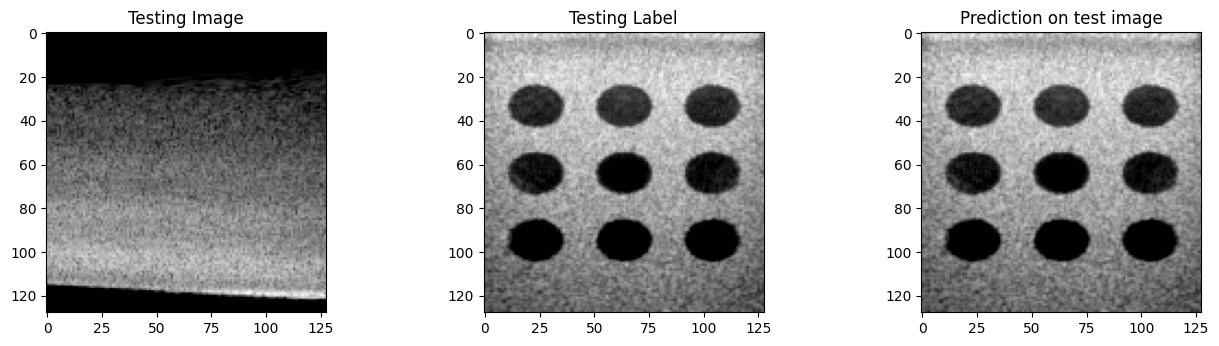

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(input, vmin=-60, cmap="gray", origin="upper")
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground, vmin=-60, cmap="gray", origin="upper")
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, vmin=-60, cmap="gray", origin="upper")

plt.show()

In [17]:
import torch
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)
torch.cuda.is_available()

import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from numpy import inf
import scipy.io as sio
import cv2
import h5py
import time

In [18]:
!pip list > requirement.txt

In [19]:
image_dataset = image_dataset[:,np.newaxis, :, :]
#image_dataset = np.tile(image_dataset, (1,16, 1, 1))
ground_truth = ground_truth[:,np.newaxis, :, :]
#mask_dataset = np.tile(mask_dataset, (1,16, 1, 1))

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, ground_truth, test_size = 0.05, random_state = 0)

In [29]:
# Hyper parameters

EPOCH = 100
BATCH_SIZE = 4
LR = 0.000001        # learning rate

torch_data = torch.from_numpy(X_train)
torch_delayed = torch.from_numpy(y_train)
train_dataset = TensorDataset(torch_data, torch_delayed)

torch_data_test = torch.from_numpy(X_test)
torch_delayed_test = torch.from_numpy(y_test)
validation_dataset = TensorDataset(torch_data_test, torch_delayed_test)

# DataLoader for easy mini-batch return in training.
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# DataLoader for easy mini-batch return in training.
validation_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
def calculate_accuracy(predictions, targets):
    # Implement your accuracy calculation logic here
    # For example, for binary classification, you can use np.mean(predictions == targets) to calculate accuracy.
    # Calculate MSE
    mse = np.mean((predictions - targets)**2)
    return mse

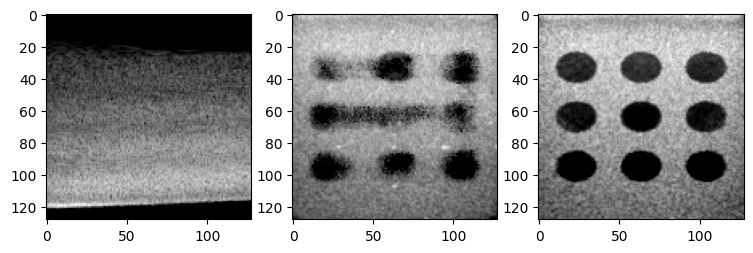

In [47]:
plt.figure(figsize=(9,6))
plt.subplot(131)
plt.imshow(inverse(X_test[7:8,:,:,:]), vmin=-60, cmap="gray", origin="upper")
plt.subplot(132)
plt.imshow(inverse_mask(outputs_CPU), vmin=-60, cmap="gray", origin="upper")
plt.subplot(133)
plt.imshow(inverse_mask(y_test[7:8,:,:,:]), vmin=-60, cmap="gray", origin="upper")
plt.show()


In [57]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [58]:
# CycleGAN generator A implementation

class Generator_A(nn.Module):

    def contracting_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=padding),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=padding),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.ReLU(),
                )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3, padding=1):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=padding),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=padding),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=padding, output_padding=1)
                    )
            return block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3, padding=1):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=padding),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=padding),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    # torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Sigmoid(),
                    )
            return block

    def bottle_neck(self, kernel_size=3, padding=1):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=256, out_channels=512, padding=padding),
                    torch.nn.BatchNorm2d(512),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=512, out_channels=512, padding=padding),
                    torch.nn.BatchNorm2d(512),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=kernel_size, stride=2, padding=padding, output_padding=1)
                    )
            return block

    def __init__(self, in_channel, out_channel):
        super(Generator_A, self).__init__()
        #Encode
        self.dropout = torch.nn.Dropout(p=0.5)
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = self.bottle_neck()
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)

    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_pool1 = self.dropout(encode_pool1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_pool2 = self.dropout(encode_pool2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        encode_pool3 = self.dropout(encode_pool3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        decode_block3 = self.dropout(decode_block3)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        decode_block2 = self.dropout(decode_block2)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        decode_block1 = self.dropout(decode_block1)
        final_layer = self.final_layer(decode_block1)
        return  final_layer

In [59]:
# CycleGAN generator B implementation

class Generator_B(nn.Module):

    def contracting_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=padding),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=padding),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.ReLU(),
                )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3, padding=1):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=padding),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=padding),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=padding, output_padding=1)
                    )
            return block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3, padding=1):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=padding),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=padding),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    # torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Sigmoid(),
                    )
            return block

    def bottle_neck(self, kernel_size=3, padding=1):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=256, out_channels=512, padding=padding),
                    torch.nn.BatchNorm2d(512),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=512, out_channels=512, padding=padding),
                    torch.nn.BatchNorm2d(512),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=kernel_size, stride=2, padding=padding, output_padding=1)
                    )
            return block

    def __init__(self, in_channel, out_channel):
        super(Generator_B, self).__init__()
        #Encode
        self.dropout = torch.nn.Dropout(p=0.5)
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = self.bottle_neck()
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)

    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_pool1 = self.dropout(encode_pool1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_pool2 = self.dropout(encode_pool2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        encode_pool3 = self.dropout(encode_pool3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        decode_block3 = self.dropout(decode_block3)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        decode_block2 = self.dropout(decode_block2)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        decode_block1 = self.dropout(decode_block1)
        final_layer = self.final_layer(decode_block1)

        return  final_layer

model_g_a = Generator_A(in_channel=1, out_channel=1).cuda()
model_g_b = Generator_B(in_channel=1, out_channel=1).cuda()

criterion_g = nn.L1Loss().cuda()
optimizer_g_a = torch.optim.Adam(model_g_a.parameters(), lr=LR, betas=(0.5, 0.999), weight_decay=1e-5)
optimizer_g_b = torch.optim.Adam(model_g_b.parameters(), lr=LR, betas=(0.5, 0.999), weight_decay=1e-5)
scheduler_g_a = torch.optim.lr_scheduler.StepLR(optimizer_g_a, step_size=50, gamma=0.3)
scheduler_g_b = torch.optim.lr_scheduler.StepLR(optimizer_g_b, step_size=50, gamma=0.3)

In [60]:
# CycleGAN [patch] discriminator A&B implementation

class Discriminator_A(nn.Module):
    def __init__(self):
        super(Discriminator_A, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 16, 4, stride=(2,2), padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 64, 4, stride=(1,2), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=(2,2), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=(1,1), padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, stride=(2,2), padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 512, 4, stride=(1,1), padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, stride=(1,1), padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.main(x)
        return output


class Discriminator_B(nn.Module):
    def __init__(self):
        super(Discriminator_B, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(128, 64, 4, stride=(2,2), padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=(1,2), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=(2,2), padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 256, 4, stride=(1,1), padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, stride=(2,2), padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 512, 4, stride=(1,1), padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, stride=(1,1), padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.main(x)
        return output

model_d_a = Discriminator_A().cuda()
model_d_b = Discriminator_B().cuda()

criterion_d = nn.BCELoss().cuda()
optimizer_d_a = torch.optim.Adam(model_d_a.parameters(), lr=LR, betas=(0.5, 0.999), weight_decay=1e-5)
optimizer_d_b = torch.optim.Adam(model_d_b.parameters(), lr=LR, betas=(0.5, 0.999), weight_decay=1e-5)
scheduler_d_a = torch.optim.lr_scheduler.StepLR(optimizer_d_a, step_size=50, gamma=0.3)
scheduler_d_b = torch.optim.lr_scheduler.StepLR(optimizer_d_b, step_size=50, gamma=0.3)

In [64]:
# Train the CycleGAN model

num = 1;
loss_da_count = np.zeros((EPOCH, num))
loss_db_count = np.zeros((EPOCH, num))
loss_ga_count = np.zeros((EPOCH, num))
loss_gb_count = np.zeros((EPOCH, num))
time_count = np.zeros((1, num))

for i in range(num):

    time_start=time.time()
    real_label = 1
    fake_label = 0
    # Lists to keep track of progress
    img_list = []
    G_A_losses = []
    G_B_losses = []
    D_A_losses = []
    D_B_losses = []
    Cycle_A_losses = []
    Cycle_B_losses = []
    iters = 0

    fake_A_buffer = ReplayBuffer()
    fake_B_buffer = ReplayBuffer()

    for epoch in range(EPOCH):
        epoch_start_time = time.time()
        for step, (a, b) in enumerate(train_loader):

            real_a = Variable(a.float().cuda())
            real_b = Variable(b.float().cuda())
            label = torch.full((real_b.size(0)*13*13,),real_label)

            ###################################
            #  Update Generator network
            ##################################
            optimizer_g_a.zero_grad()

            # generate real A to fake B; D_A(G_A(A))
            fake_b = model_g_a(real_a)
            result_d_a = model_d_a(fake_b).view(-1)
            loss_g_a = criterion_d(result_d_a, label.cuda())
            # reconstruct fake B to rec A; G_B(G_A(A))
            recon_a = model_g_b(fake_b)
            cycleloss_a = criterion_g(recon_a, real_a) * 50
            loss_ga = loss_g_a + cycleloss_a

            # Update G
            loss_ga.backward()
            optimizer_g_a.step()

            # generate real B to fake A; D_A(G_B(B))
            fake_a = model_g_b(real_b)
            result_d_b = model_d_b(fake_a).view(-1)
            loss_g_b = criterion_d(result_d_b, label.cuda())
            # reconstruct fake A to rec B G_A(G_B(B))
            recon_b = model_g_a(fake_a)
            cycleloss_b = criterion_g(recon_b, real_b) * 50
            # loss_g = loss_g_a + loss_g_b + cycleloss_a + cycleloss_b
            loss_gb = loss_g_b + cycleloss_b

            # Update G
            loss_gb.backward()
            optimizer_g_b.step()

            ###################################
            #  Update Discriminator A network
            ##################################
            optimizer_d_a.zero_grad()

            # train discriminator D_A
            real_d_a = model_d_a(real_b).view(-1)
            loss_d_a_real = criterion_d(real_d_a, label.cuda())
            label.fill_(fake_label)
            # fake_b = fake_A_buffer.push_and_pop(fake_b)
            fake_d_a= model_d_a(fake_b.detach()).view(-1)
            loss_d_a_fake = criterion_d(fake_d_a, label.cuda())
            loss_d_a = (loss_d_a_real + loss_d_a_fake) * 0.5

            # Update D_A
            loss_d_a.backward()
            optimizer_d_a.step()

            ###################################
            #  Update Discriminator B network
            ##################################
            optimizer_d_b.zero_grad()

            # train discriminator D_B
            label.fill_(real_label)
            # fake_a = fake_A_buffer.push_and_pop(fake_a)
            real_d_b = model_d_b(real_a).view(-1)
            loss_d_b_real = criterion_d(real_d_b, label.cuda())
            label.fill_(fake_label)
            fake_d_b= model_d_b(fake_a.detach()).view(-1)
            loss_d_b_fake = criterion_d(fake_d_b, label.cuda())
            loss_d_b = (loss_d_b_real + loss_d_b_fake) * 0.5

            # Update D_B
            loss_d_b.backward()
            optimizer_d_b.step()

        scheduler_d_a.step()
        scheduler_g_a.step()
        scheduler_d_b.step()
        scheduler_g_b.step()

        loss_da_count[epoch, i] = loss_d_a.item()
        loss_db_count[epoch, i] = loss_d_b.item()
        loss_ga_count[epoch, i] = loss_g_a.item()
        loss_gb_count[epoch, i] = loss_g_b.item()

        print('Epoch: [%d/%d]\t Loss_DA: %.4f, Loss_DB: %.4f, Loss_GA: %.4f, Loss_GB: %.4f, Loss_CA: %.4f, Loss_CB: %.4f'
              % (epoch, EPOCH, loss_d_a.item(), loss_d_b.item(), loss_g_a.item(), loss_g_b.item(), cycleloss_a.item(), cycleloss_b.item()))

    time_end=time.time()
    time_count[0, i] = time_end-time_start
    print('time cost',time_count[0, i],'s')

    plt.figure(figsize=(6,3))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(loss_ga_count[:, i],label="G_A")
    plt.plot(loss_gb_count[:, i],label="G_B")
    plt.plot(loss_da_count[:, i],label="D_A")
    plt.plot(loss_db_count[:, i],label="D_B")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.show()

ValueError: ignored